https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset (uploaded to my drie as a .rar file)

This project implements a deep learning pipeline for automated plant disease detection using convolutional neural networks (CNNs). Leveraging the publicly available PlantVillage dataset, the objective was to train a model capable of accurately identifying plant species and diagnosing leaf diseases from image data. The process begins with structured dataset preparation and real-time image augmentation to improve generalization. A carefully designed CNN model was then trained, evaluated, and saved for future use. Performance was measured using a variety of metrics including accuracy, confusion matrices, top-k accuracy, and per-class precision, recall, and F1 scores. These metrics, along with visual diagnostics such as prediction confidence plots and misclassified examples, provide a detailed view of the model’s strengths and weaknesses. The end-to-end workflow is designed to be reproducible, scalable, and deployment-ready.



In [1]:
# linking google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!ls -lh /content/drive/MyDrive/PlantVillage.rar


-rw------- 1 root root 819M May  9 12:36 /content/drive/MyDrive/PlantVillage.rar


In [9]:
# Install unrar
#!apt-get install -y unrar

# Extract RAR file
#RAR_PATH = '/content/drive/MyDrive/PlantVillage.rar'
#EXTRACT_PATH = '/content/drive/MyDrive/PlantVillage'

#!unrar x -o+ "{RAR_PATH}" "{EXTRACT_PATH}"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/PlantVillage.rar

No files to extract


In [10]:
# extracting .rar file to google drive
!rm -r "/content/drive/MyDrive/PlantVillage"
!unrar x "/content/drive/MyDrive/PlantVillage.rar" "/content/drive/MyDrive/PlantVillage/"


Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/MyDrive/PlantVillage/PlantVillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1104914f-f715-4b02-b551-5cdf03f54bcb___YLCV_NREC 2717.JPG      92%  OK 
Extracting  /content/drive/MyDrive/PlantVillage/PlantVillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus/11061195-ce9c-4171-819d-663342a186e8___YLCV_NREC 0257.JPG      92%  OK 
Extracting  /content/drive/MyDrive/PlantVillage/PlantVillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus/110c50e6-039e-4f32-bda1-26262968ab8a___YLCV_GCREC 5539.JPG      92%  OK 
Extracting  /content/drive/MyDrive/PlantVillage/PlantVillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus/1114e83e-5477-483c-8bed-847b2c169c9f___YLCV_NREC 2257.JPG      92%  OK 
Extracting  /content/drive/MyDrive/PlantVillage/PlantVillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus/111d4096-e9eb-4f32-9a25-f3c19b92c627___YLCV_GCREC 2209.JPG      92%  OK 
Extracting  /content/drive/MyDrive/PlantVi

In [16]:
# Setting the path to the extracted dataset, which we will later read into a DataFrame
# The nested folder name here suggests that the .rar archive contains an inner directory also called 'PlantVillage'
DATASET_DIR = '/content/drive/MyDrive/PlantVillage/PlantVillage'
print("Dataset directory set to:", DATASET_DIR)


Dataset directory set to: /content/drive/MyDrive/PlantVillage/PlantVillage


Total images: 54305


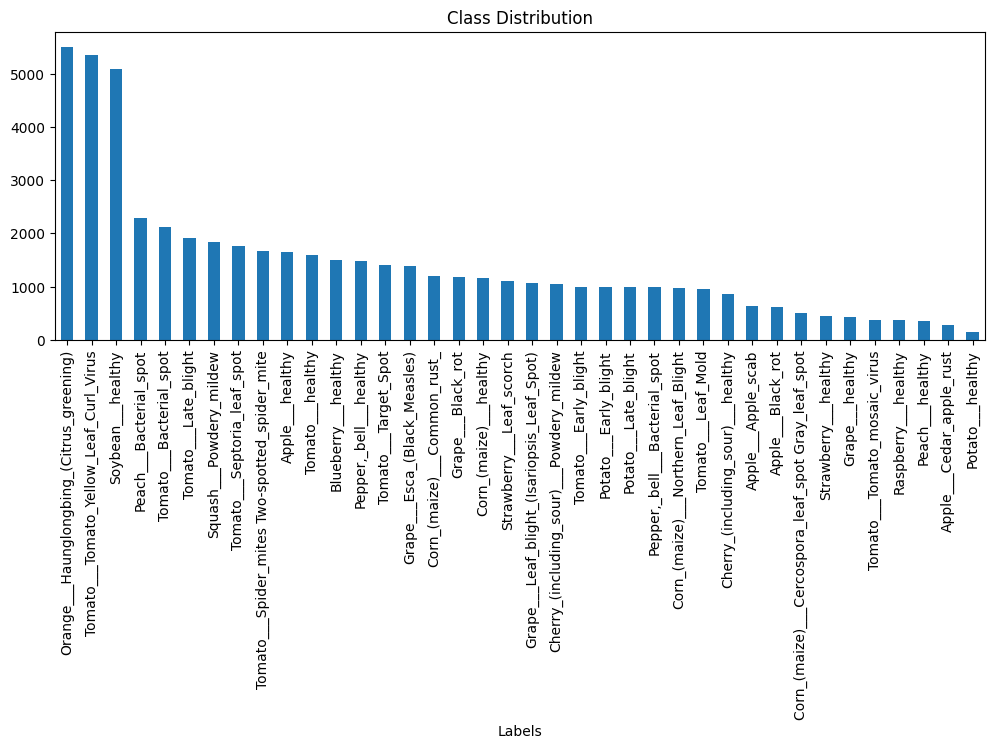

In [17]:
# Importing all necessary libraries for data manipulation, visualization, and model development
# These are standard for image classification tasks using Keras/TensorFlow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


# Function to walk through the dataset folder and create a DataFrame
# Each image is assigned a filepath and its label based on its parent folder name
# This structure supports automated class labeling when using flow_from_dataframe()
def create_dataframe(data_path):
    filepaths = []
    labels = []
    for label in sorted(os.listdir(data_path)):
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            continue
        for fname in os.listdir(label_path):
            filepaths.append(os.path.join(label_path, fname))
            labels.append(label)
    return pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})

# Generate the dataset DataFrame
df = create_dataframe(DATASET_DIR)

# Display dataset overview
print("Total images:", len(df))

# Plotting the class distribution to understand dataset balance
df['Labels'].value_counts().plot(kind='bar', figsize=(12,4), title="Class Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
# Verifying the number of distinct classes (label folders) in the dataset
# This ensures the extraction and preprocessing steps have preserved the correct structure
print("Unique class folders found:", df['Labels'].nunique())

# Printing the count of images per class to assess class imbalance
# This information is critical for evaluating model fairness and might influence later decisions
# such as whether to apply class weighting, oversampling, or to focus augmentation on underrepresented classes
print(df['Labels'].value_counts())


Unique class folders found: 38
Labels
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot 

In [19]:
# First, we split the dataset into 80% training and 20% temporary (to be split into validation and test)
# Stratification ensures that the class distribution is preserved across all subsets
# This is especially important in classification tasks with imbalanced or fine-grained labels
train_df, temp_df = train_test_split(df, train_size=0.8, stratify=df['Labels'], random_state=42)

# Next, we split the remaining 20% into two equal halves: 10% validation and 10% test
# Validation is used for tuning model performance during training,
# while the test set is held out entirely to evaluate final model generalization
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['Labels'], random_state=42)


In [20]:
# Defining image dimensions and batch size for training
# 128x128 strikes a good balance between computational efficiency and preserving detail
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# Setting up the training image generator with real-time data augmentation
# These transformations simulate common variations like rotation, zoom, and translation
# The goal is to improve model generalization by exposing it to more diverse image conditions during training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation and test sets are only rescaled — no augmentation
# This ensures performance is evaluated on consistent, real-world representations
valid_test_gen = ImageDataGenerator(rescale=1./255)

# Creating the training data pipeline
train_data = train_gen.flow_from_dataframe(train_df, x_col='Filepaths', y_col='Labels', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True)

# Validation data pipeline — no shuffle to preserve order for metrics
valid_data = valid_test_gen.flow_from_dataframe(valid_df, x_col='Filepaths', y_col='Labels', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

# Test data pipeline — also no shuffle, so we can later match predictions to filenames
test_data = valid_test_gen.flow_from_dataframe(test_df, x_col='Filepaths', y_col='Labels', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)


Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


In [22]:
# Building a Convolutional Neural Network using Keras Sequential API
# The architecture is designed to balance learning capacity and computational efficiency
# It includes multiple convolutional blocks, each followed by max pooling and batch normalization
model = Sequential([

    # First convolutional block: small filter count to reduce computation
    Conv2D(16, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D(2, 2),              # Downsamples feature maps to reduce dimensionality
    BatchNormalization(),            # Normalizes activations to stabilize training

    # Second block: more filters to capture more complex patterns
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Third block: even deeper filters for abstract features
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Flatten feature maps before feeding into dense layers
    Flatten(),

    # Dense layer for high-level reasoning
    Dense(64, activation='relu'),
    Dropout(0.5),                    # Dropout prevents overfitting by randomly disabling neurons during training

    # Output layer with softmax for multi-class classification
    Dense(len(train_data.class_indices), activation='softmax')
])

# Compile the model with:
# - Adam optimizer for adaptive learning rate
# - Categorical crossentropy for multi-class classification
# - Accuracy as a metric for monitoring during training
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary to verify layer dimensions and parameter count
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,382 (3.16 MB)

 Trainable params: 829,158 (3.16 MB)

 Non-trainable params: 224 (896.00 B)

In [23]:
# Defining the number of epochs — 5 is used here for quick experimentation and to reduce overfitting risk
# In a real deployment or final experiment, this can be increased or paired with early stopping
EPOCHS = 5

# Training the model using the prepared training data generator
# Validation data is used at the end of each epoch to monitor generalization performance
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS
)


Epoch 1/5
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 379s 137ms/step - accuracy: 0.2443 - loss: 3.1740 - val_accuracy: 0.3764 - val_loss: 3.3706
Epoch 2/5
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 365s 132ms/step - accuracy: 0.3381 - loss: 2.4598 - val_accuracy: 0.5024 - val_loss: 1.8593
Epoch 3/5
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 357s 131ms/step - accuracy: 0.4018 - loss: 2.1655 - val_accuracy: 0.5192 - val_loss: 1.9170
Epoch 4/5
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 363s 134ms/step - accuracy: 0.4623 - loss: 1.8910 - val_accuracy: 0.6368 - val_loss: 1.3522
Epoch 5/5
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 368s 136ms/step - accuracy: 0.5108 - loss: 1.6948 - val_accuracy: 0.6650 - val_loss: 1.1707


In [24]:
# Saving the trained model to Google Drive for reuse
# This prevents the need to retrain the model in future sessions, which is critical in Colab where runtimes reset
model.save('/content/drive/MyDrive/plant_disease_model.h5')

# Confirmation message to indicate that the save operation was successful
print("Model saved.")


Model saved.


In [25]:
# Importing the load_model function from Keras to restore a previously saved model
from tensorflow.keras.models import load_model

# Loading the model file saved to Google Drive
# This allows us to skip training and go straight to evaluation or inference
model = load_model('/content/drive/MyDrive/plant_disease_model.h5')


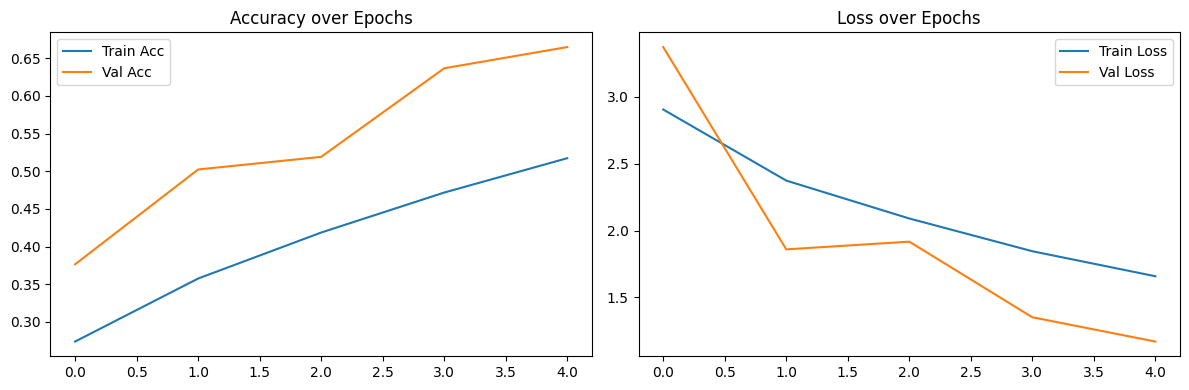

In [26]:
# Plotting accuracy and loss curves for both training and validation sets
# These plots help visually assess model performance and identify signs of overfitting or underfitting

plt.figure(figsize=(12, 4))  # Create a wide figure with two subplots

# Subplot 1: Accuracy trend over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')           # Training accuracy
plt.plot(history.history['val_accuracy'], label='Val Acc')         # Validation accuracy
plt.title('Accuracy over Epochs')
plt.legend()

# Subplot 2: Loss trend over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')              # Training loss
plt.plot(history.history['val_loss'], label='Val Loss')            # Validation loss
plt.title('Loss over Epochs')
plt.legend()

# Adjust layout to avoid overlapping plots
plt.tight_layout()
plt.show()


Accuracy curve shows how well the model is learning to generalize to unseen data

Loss curve reveals potential issues like:

Overfitting: Validation loss increases while training loss continues to drop

Underfitting: Both losses remain high

Helps guide decisions on early stopping, regularization, or increasing model complexity

340/340 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.17      0.02      0.03        63
                                 Apple___Black_rot       0.54      0.21      0.30        62
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        27
                                   Apple___healthy       0.48      0.44      0.46       165
                               Blueberry___healthy       0.45      0.66      0.53       150
          Cherry_(including_sour)___Powdery_mildew       0.90      0.60      0.72       105
                 Cherry_(including_sour)___healthy       0.67      0.62      0.65        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.40      0.04      0.07        51
                       Corn_(maize)___Common_rust_       0.87      1.00      0.93       120
             

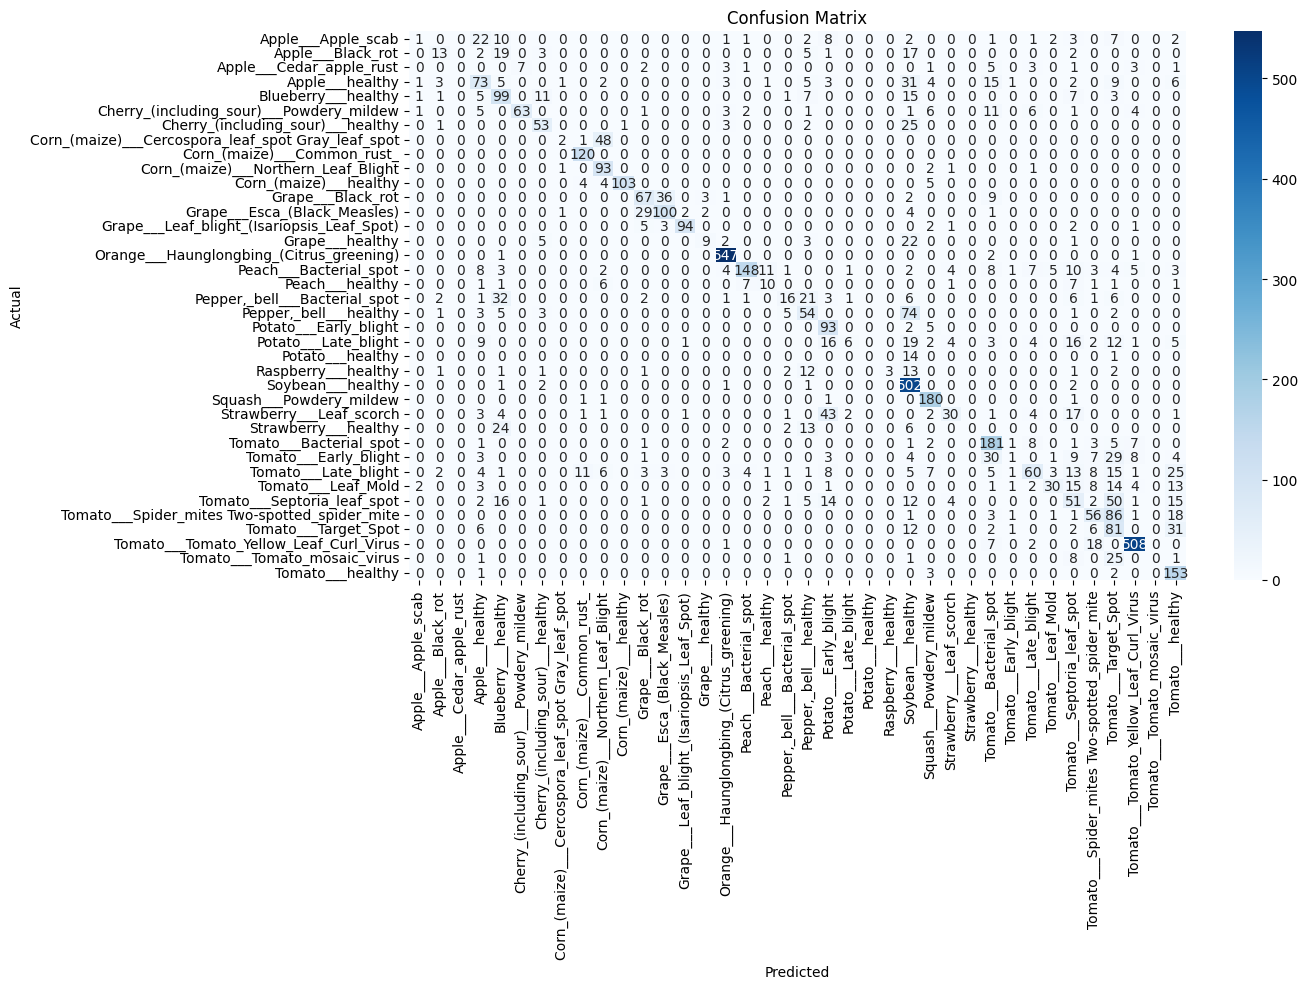

Model saved to /content/plant_disease_cnn_colab_rar.h5


In [27]:
# Generate class probabilities for each image in the test set
# These are the softmax output scores, used for both prediction and confidence analysis
predictions = model.predict(test_data, verbose=1)

# Convert predicted probabilities to actual class indices (highest probability = predicted class)
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
y_true = test_data.classes


# Print a detailed classification report showing precision, recall, F1-score for each class
# This helps us evaluate model performance beyond just overall accuracy — especially for unbalanced datasets
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

# Generate and plot a confusion matrix to visualize where the model is making errors
# The heatmap makes it easy to see which class predictions are often confused
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Saving the evaluated model again under a new name for backup or future testing
# This ensures you can distinguish this version from earlier checkpoints
model.save("/content/plant_disease_cnn_colab_rar.h5")
print("Model saved to /content/plant_disease_cnn_colab_rar.h5")



The confusion matrix shows that the model is generally effective at correctly classifying many of the leaf diseases and plant types. Several classes exhibit strong diagonal dominance, which indicates high classification accuracy. For example, Grape___healthy, Corn_(maize)___Common_rust, and Tomato___Tomato_Yellow_Leaf_Curl_Virus are predicted with high precision, suggesting that their visual features are distinctive and well-represented in the training data.

However, there are also areas of significant confusion. In particular, the model struggles to distinguish between similar tomato diseases such as Tomato___Leaf_Mold, Tomato___Septoria_leaf_spot, and Tomato___Spider_mites Two-spotted_spider_mite. These classes often display visually similar symptoms (e.g., speckling, discoloration, or leaf damage) that are difficult to differentiate using raw image data alone. Misclassifications within these classes may be exacerbated by overlapping symptom presentation, inconsistent lighting, or insufficient training examples for certain conditions.

The model also shows confusion among apple diseases, notably Apple___Black_rot, Apple___scab, and Apple___Cedar_apple_rust. Again, this is likely due to the similarity in leaf texture and damage patterns caused by these diseases, as well as the fact that all affect the same host plant.

There are also several instances where healthy leaves are misclassified as diseased and vice versa. This behavior suggests that the model may be sensitive to image artifacts such as lighting conditions, shadows, or natural blemishes on healthy leaves. Such misclassifications highlight the importance of robust preprocessing and the potential value of introducing more sophisticated features through transfer learning.

In terms of class distribution, some low-frequency classes (e.g., Raspberry___healthy, Squash___Powdery_mildew) demonstrate higher confusion, which may be attributed to underrepresentation in the training dataset. These classes could benefit from targeted augmentation or class rebalancing strategies.

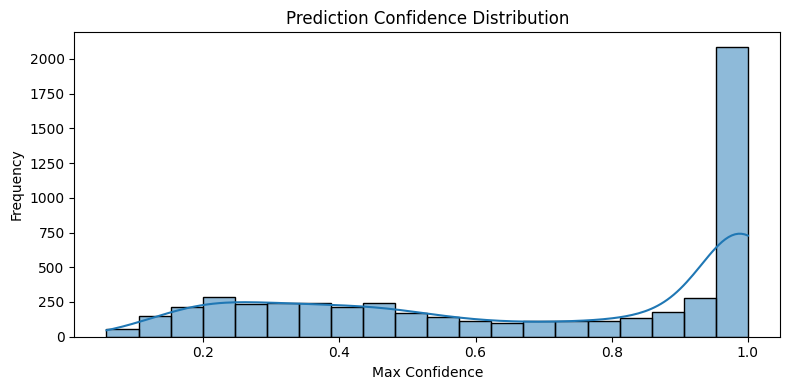

In [30]:
# Extracting the highest predicted probability for each test sample
# This represents the model's confidence in its chosen class
confidences = np.max(pred_probs, axis=1)

# Plotting a histogram of prediction confidences across the test set
# This gives insight into how certain or uncertain the model is in its predictions
plt.figure(figsize=(8, 4))
sns.histplot(confidences, bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Confidence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


A tight concentration near 1.0 suggests the model is very confident in most predictions — but overconfidence could signal overfitting.

A broad distribution or peak around 0.5–0.7 indicates the model is uncertain — which may suggest class confusion, poor feature separation, or noise in the data.

This plot helps determine if a confidence threshold should be applied before accepting predictions (e.g., flagging low-confidence cases for manual review).

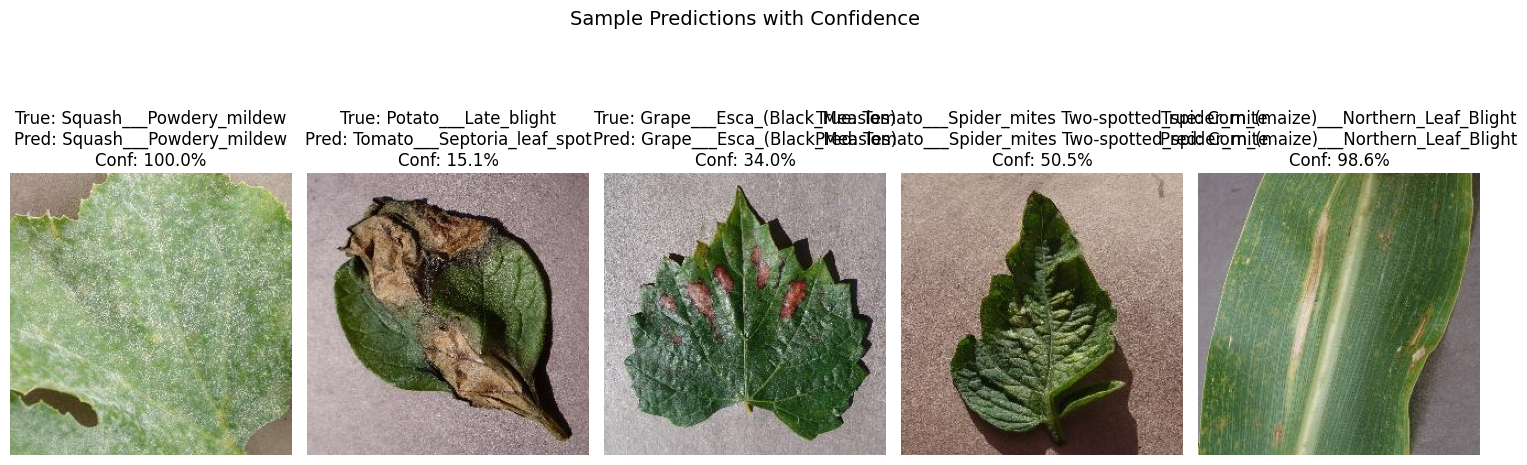

In [31]:
# Selecting 5 random indices from the test set for manual inspection
# This helps us evaluate how well the model is performing on a few specific examples
import random
sample_indices = random.sample(range(len(test_data.filenames)), 5)

# Create a horizontal row of subplots to display the chosen images
plt.figure(figsize=(15, 6))

# Loop through selected indices to load and annotate each image
for i, idx in enumerate(sample_indices):
    image_path = test_data.filepaths[idx]
    image = plt.imread(image_path)

    # Extract the true and predicted labels
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    # Get the prediction confidence for the predicted class
    confidence = np.max(pred_probs[idx]) * 100

    # Plot the image and annotate with labels and confidence
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {true_label}\\nPred: {pred_label}\\nConf: {confidence:.1f}%')

# Add a shared title above all subplots
plt.suptitle("Sample Predictions with Confidence", fontsize=14)
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute top-k accuracy
# This checks if the true label is among the model's top-k predicted classes
# Useful for evaluating performance in high-class-count tasks where even close guesses matter
def top_k_accuracy(y_true, y_probs, k=1):
    top_k_preds = np.argsort(y_probs, axis=1)[:, -k:]  # Extract the top k class indices
    correct = sum(y_true[i] in top_k_preds[i] for i in range(len(y_true)))  # Check if true class is in top k
    return correct / len(y_true)

# Compute top-k accuracy scores for k = 1 through 5
# Top-1 is standard accuracy, while higher k values tell us how often the model 'almost got it right'
topk_scores = []
for k in range(1, 6):
    acc = top_k_accuracy(y_true, predictions, k=k)
    topk_scores.append(acc)
    print(f"Top-{k} Accuracy: {acc:.4f}")


Top-1 Accuracy: 0.6629
Top-2 Accuracy: 0.7871
Top-3 Accuracy: 0.8418
Top-4 Accuracy: 0.8796
Top-5 Accuracy: 0.9061


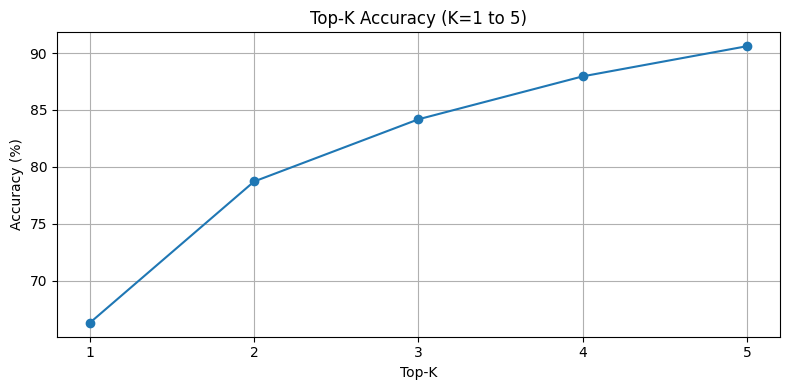

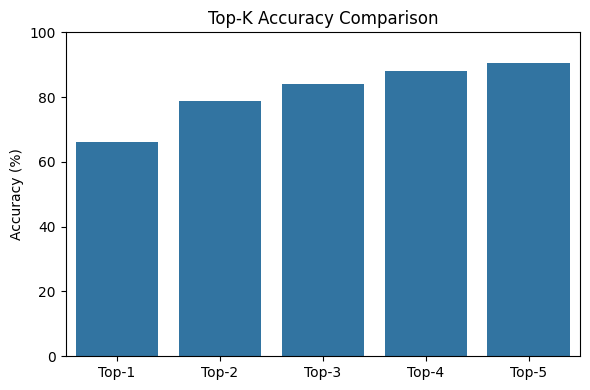

In [37]:
# Line plot showing how accuracy improves as we allow more prediction flexibility (top-k)
# This helps assess whether the model is making reasonable second or third guesses even when it gets the top prediction wrong
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), [score * 100 for score in topk_scores], marker='o')
plt.title("Top-K Accuracy (K=1 to 5)")
plt.xlabel("Top-K")
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar chart provides a clearer, side-by-side comparison of top-k accuracy values
# It complements the line plot and makes it easier to report or visually explain the results in presentations
plt.figure(figsize=(6, 4))
sns.barplot(x=[f"Top-{i}" for i in range(1, 6)], y=[s * 100 for s in topk_scores])
plt.title("Top-K Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()



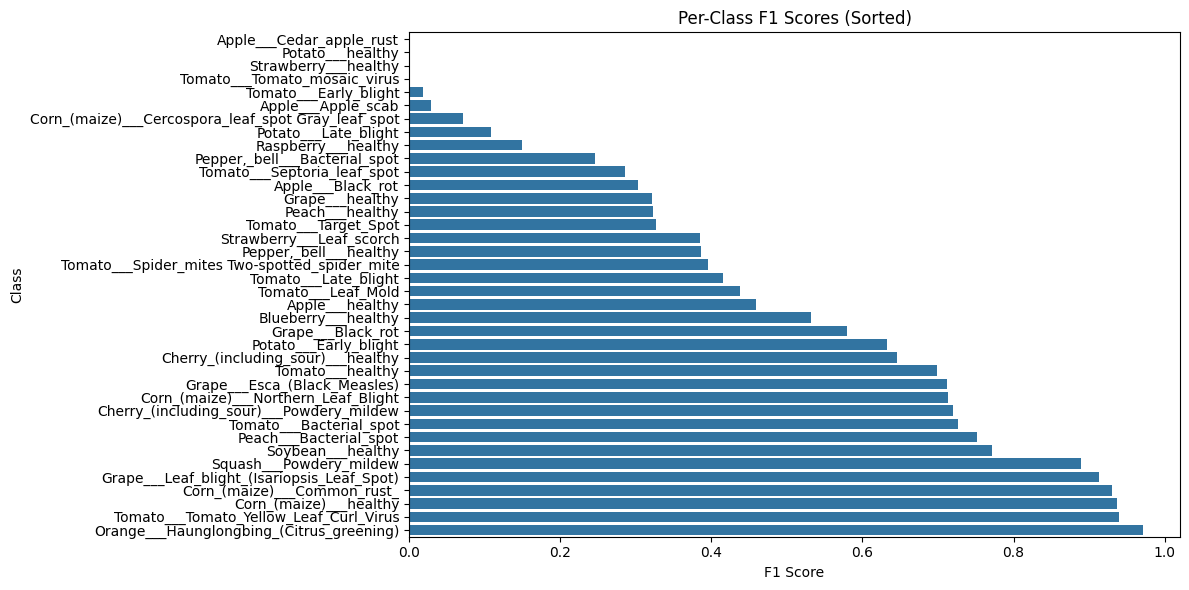

In [39]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Generate precision, recall, and F1-score for each class
# This provides a granular view of how the model performs across different labels — not just overall
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)

# Build a DataFrame to store per-class metrics
# Sorting by F1-score allows us to focus on the weakest-performing classes first
metrics_df = pd.DataFrame({
    'Class': list(test_data.class_indices.keys()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).sort_values(by='F1-Score')

# Reset index for clean display
metrics_df.reset_index(drop=True, inplace=True)

# Display the 10 classes with the lowest F1 scores
# These are the most likely sources of misclassification or data imbalance
metrics_df.head(10)


# Bar plot showing F1 scores for each class, sorted from lowest to highest
# This plot highlights which classes are most problematic and may need:
# - More training data
# - Better image quality
# - Class merging or relabeling
plt.figure(figsize=(12, 6))
sns.barplot(x='F1-Score', y='Class', data=metrics_df)
plt.title("Per-Class F1 Scores (Sorted)")
plt.xlabel("F1 Score")
plt.ylabel("Class")
plt.tight_layout()
plt.show()



The per-class F1 score chart highlights substantial variation in model performance across different disease categories. While several classes such as Orange___Haunglongbing_(Citrus_greening) and Tomato___Tomato_Yellow_Leaf_Curl_Virus show excellent F1 scores close to 1.0, others like Apple___Cedar_apple_rust, Potato___healthy, and Tomato___Tomato_mosaic_virus perform poorly, with F1 scores well below 0.3. These low scores indicate that the model struggles to distinguish these classes, possibly due to overlapping visual features, underrepresentation in the training set, or subtle symptom presentation. This analysis helps prioritize which classes need more data, augmentation, or potential relabeling.

The results demonstrate that the model performs well overall, particularly on well-represented and visually distinctive classes. However, the evaluation also reveals areas where performance degrades — especially in classes with subtle visual differences or fewer training samples. Per-class F1 score analysis highlights specific categories that would benefit from further augmentation or relabeling. The confidence distribution and top-k accuracy analysis suggest the model has the potential to be reliable but should be used with a confidence threshold to avoid overconfident misclassifications. Overall, the project achieves its primary goal of building a working, interpretable plant disease detection model, and also lays the groundwork for meaningful future improvements through deeper model architectures, class rebalancing, or transfer learning.

